In [7]:
import pandas as pd
import psycopg2 as ps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import plotly.graph_objs as go
from prophet import Prophet
from matplotlib.lines import Line2D
from matplotlib.dates import YearLocator, DateFormatter
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.serialize import model_to_json
from datetime import datetime
from datetime import timedelta


In [8]:
df = pd.read_excel('ipeadata.xls')

In [9]:
# VISUALIZANDO AS 10 PRIMEIRAS LINHAS #

df.head(10)


data  preco_brent
0  20/05/1987        18.63
1  21/05/1987        18.45
2  22/05/1987        18.55
3  25/05/1987        18.60
4  26/05/1987        18.63
5  27/05/1987        18.60
6  28/05/1987        18.60
7  29/05/1987        18.58
8  01/06/1987        18.65
9  02/06/1987        18.68

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11203 entries, 0 to 11202
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   data         11203 non-null  object 
 1   preco_brent  11203 non-null  float64
dtypes: float64(1), object(1)
memory usage: 175.2+ KB


In [11]:
# Transformando o formato "data"

df['data']= pd.to_datetime(df['data'])

C:\Users\claud\AppData\Local\Temp\ipykernel_9360\2657559716.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['data']= pd.to_datetime(df['data'])


In [12]:
# VISUALIZANDO INFORMAÇÕES #

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11203 entries, 0 to 11202
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         11203 non-null  datetime64[ns]
 1   preco_brent  11203 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.2 KB


In [13]:
# Procurando linhas vazias #

df.isnull().sum()

data           0
preco_brent    0
dtype: int64

In [14]:
df_dados = df[['data','preco_brent']]

In [15]:
df_dados['ano'] = df['data'].dt.year
df_dados['mes'] = df['data'].dt.month
df_dados['dia'] = df['data'].dt.day

In [16]:
df_dados.head(10)

data  preco_brent   ano  mes  dia
0 1987-05-20        18.63  1987    5   20
1 1987-05-21        18.45  1987    5   21
2 1987-05-22        18.55  1987    5   22
3 1987-05-25        18.60  1987    5   25
4 1987-05-26        18.63  1987    5   26
5 1987-05-27        18.60  1987    5   27
6 1987-05-28        18.60  1987    5   28
7 1987-05-29        18.58  1987    5   29
8 1987-06-01        18.65  1987    6    1
9 1987-06-02        18.68  1987    6    2

In [17]:
# Quais os anos analisados ?

print(f'Anos analisados:{df_dados.ano.unique()}')

Anos analisados:[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [18]:
# Maiores preços do Petroleo Brent no período total

df_sorted = df_dados.sort_values(by='preco_brent', ascending=False)
df_sorted.head()

data  preco_brent   ano  mes  dia
6045 2008-07-07       143.95  2008    7    7
6041 2008-07-03       143.95  2008    7    3
6053 2008-07-15       143.68  2008    7   15
6056 2008-07-18       142.43  2008    7   18
6044 2008-07-06       141.24  2008    7    6

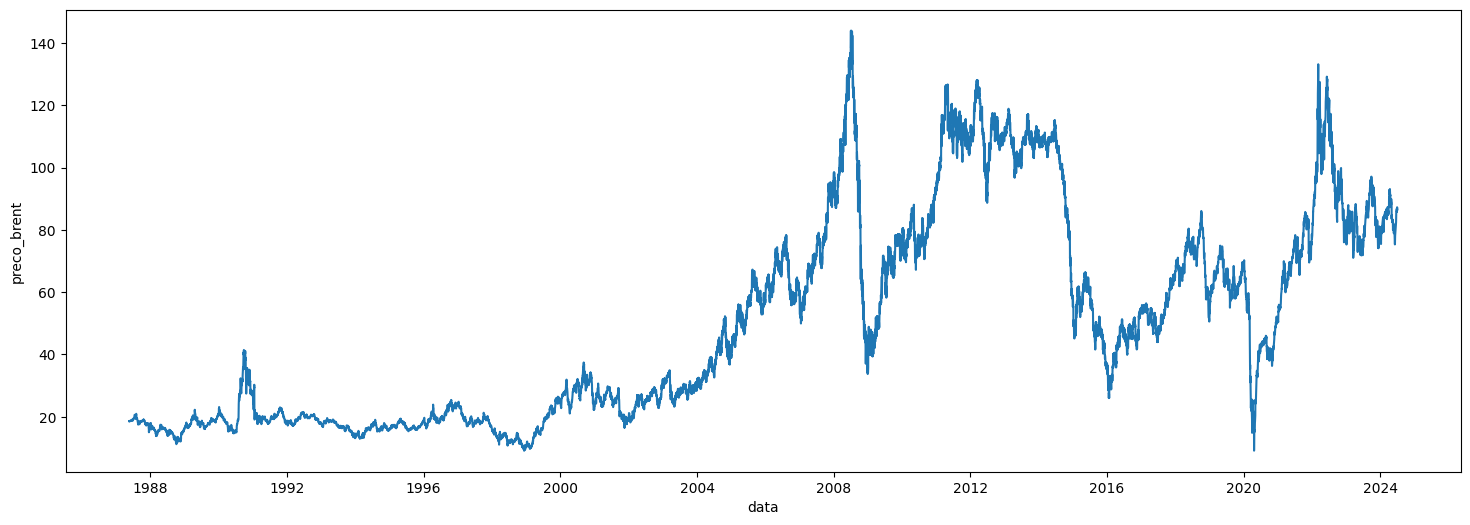

In [19]:
# Gráfico indicando a variação de preço do petróleo Brent durante todo o período

ax = sns.lineplot(data = df_dados, x='data', y='preco_brent',)
ax.figure.set_size_inches(18,6)

In [20]:
print(df)

            data  preco_brent
0     1987-05-20        18.63
1     1987-05-21        18.45
2     1987-05-22        18.55
3     1987-05-25        18.60
4     1987-05-26        18.63
...          ...          ...
11198 2024-06-25        86.81
11199 2024-06-26        85.76
11200 2024-06-27        87.00
11201 2024-06-28        87.26
11202 2024-07-01        86.57

[11203 rows x 2 columns]


In [21]:
df.nunique()

data           11203
preco_brent     5261
dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11203 entries, 0 to 11202
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         11203 non-null  datetime64[ns]
 1   preco_brent  11203 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.2 KB


In [23]:
# VALOR MÁXIMO REGISTRADO #

max_value = df_dados['preco_brent'].max()
print(max_value)

143.95


In [24]:
# VALOR MÍNIMO REGISTRADO #

min_value = df_dados['preco_brent'].min()
print(min_value)

9.1


In [25]:
# VALOR MÉDIO #

mean_value = df_dados['preco_brent'].mean()
print(mean_value)

53.11047844327412


In [26]:
# DESVIO PADRÃO #

desvio_padrao = df_dados['preco_brent'].std()
print(desvio_padrao)

33.21582115966959


In [27]:
# MEDIANA #

mediana = df_dados['preco_brent'].median()
print(mediana)

48.4


In [28]:
# PRIMEIRO QUARTIL 25% #

primeiro_quartil = df_dados['preco_brent'].quantile(0.25)
print(primeiro_quartil)

20.53


In [29]:
# SEGUNDO QUARTIL 50% #

segundo_quartil = df_dados['preco_brent'].quantile(0.50)
print(segundo_quartil)

48.4


In [30]:
# TERCEIRO QUARTIL 75% #

terceiro_quartil = df_dados['preco_brent'].quantile(0.75)
print(terceiro_quartil)

76.61


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11203 entries, 0 to 11202
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         11203 non-null  datetime64[ns]
 1   preco_brent  11203 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.2 KB


<Axes: xlabel='preco_brent', ylabel='Count'>

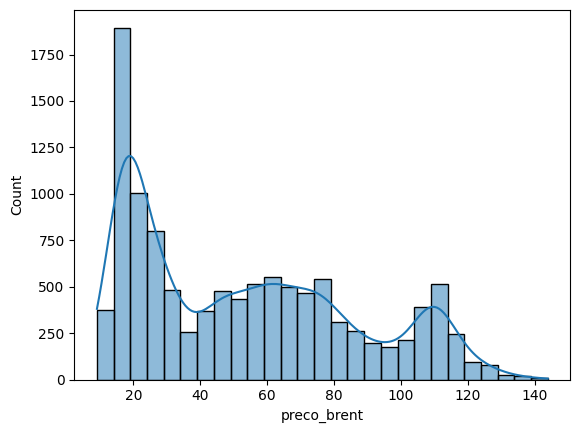

In [32]:
# GERANDO O HISTOGRAMA

sns.histplot(data=df.preco_brent, kde=True)

<Axes: ylabel='preco_brent'>

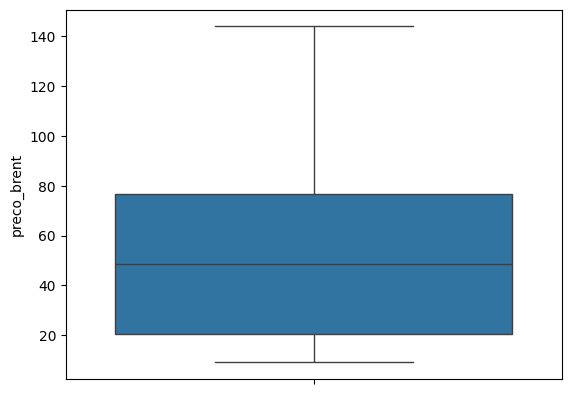

In [33]:
# GERANDO O BOXPLOT

sns.boxplot(data=df.preco_brent)

In [34]:
# CRIANDO MODELO ML

def plot_eventos(ponto: pd.Series, id_evento: int):
  if not ponto.empty:
    plt.scatter(ponto.date, float(ponto.preco_brent), s=200, facecolors='none', edgecolors='red', linewidths=2)
    plt.text(ponto.date, float(ponto.preco_brent) + 4, id_evento, ha='center', va='center', fontsize=8, fontweight='bold', color='red', bbox=dict(facecolor='white', alpha=0.4, edgecolor='red', boxstyle='round', lw=2))


C:\Users\claud\AppData\Local\Temp\ipykernel_9360\1357259210.py:47: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  plot_eventos(df.query('data == "1990-08-02"'), 1)
C:\Users\claud\AppData\Local\Temp\ipykernel_9360\1357259210.py:48: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  plot_eventos(df.query('data == "2001-09-11"'), 2)
C:\Users\claud\AppData\Local\Temp\ipykernel_9360\1357259210.py:49: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitl

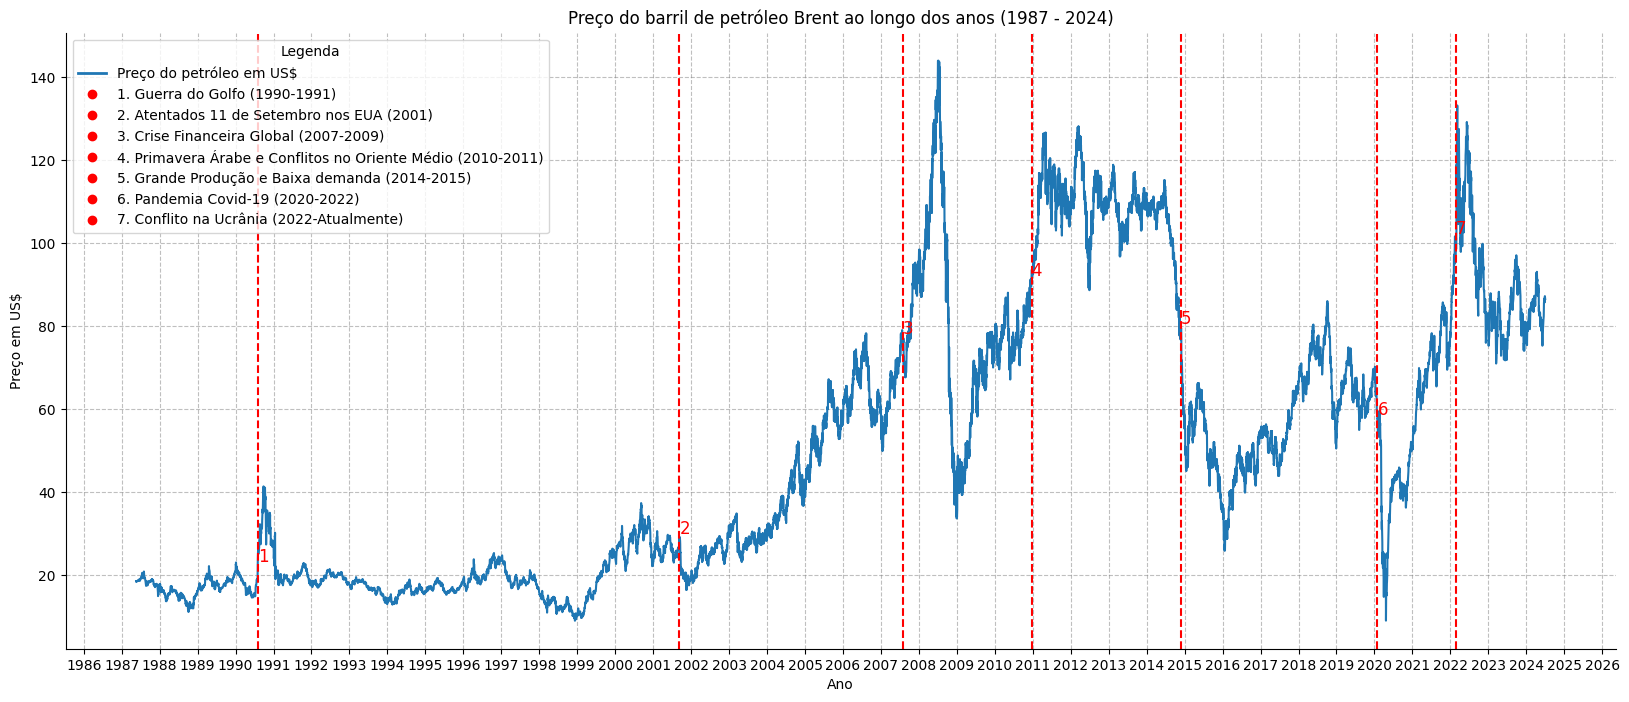

In [35]:
# CRIANDO MODELO ML

def plot_eventos(ponto: pd.Series, id_evento: int):
  if not ponto.empty:
    plt.scatter(ponto.date, float(ponto.preco_brent), s=200, facecolors='none', edgecolors='red', linewidths=2)
    plt.text(ponto.date, float(ponto.preco_brent) + 4, id_evento, ha='center', va='center', fontsize=8, fontweight='bold', color='red', bbox=dict(facecolor='white', alpha=0.4, edgecolor='red', boxstyle='round', lw=2))

# Função para configurar a legenda

def set_legenda():
    legend_handles, _ = plt.gca().get_legend_handles_labels()
    extra_labels = [
        ('Preço do petróleo em US$', '#1F77B4', 'line'),
        ('1. Guerra do Golfo (1990-1991)', 'red', 'dot'),
        ('2. Atentados 11 de Setembro nos EUA (2001)', 'red', 'dot'),
        ('3. Crise Financeira Global (2007-2009)', 'red', 'dot'),
        ('4. Primavera Árabe e Conflitos no Oriente Médio (2010-2011)', 'red', 'dot'),
        ('5. Grande Produção e Baixa demanda (2014-2015)', 'red', 'dot'),
        ('6. Pandemia Covid-19 (2020-2022)', 'red', 'dot'),
        ('7. Conflito na Ucrânia (2022-Atualmente)', 'red', 'dot')
    ]

    for label, color, linestyle in extra_labels:
        if linestyle == 'line':
            legend_handles.append(Line2D([0], [0], color=color, lw=2, label=label))
        elif linestyle == 'dot':
            legend_handles.append(Line2D([0], [0], color=color, marker='o', linestyle='', label=label))

    plt.legend(title='Legenda', loc='upper left', handles=legend_handles)

# Função para plotar eventos importantes
def plot_eventos(df_evento, evento_id):
    for _, row in df_evento.iterrows():
        plt.axvline(x=row['data'], color='red', linestyle='--')
        plt.text(row['data'], row['preco_brent'], str(evento_id), color='red', fontsize=12, verticalalignment='bottom')


# Configurarando o gráfico
plt.figure(figsize=(20, 8))
ax = sns.lineplot(data=df, x='data', y='preco_brent', legend=False)
ax.set_ylabel('Preço em US$')
ax.set_xlabel('Ano')
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

# Plotar os eventos importantes
plot_eventos(df.query('data == "1990-08-02"'), 1)
plot_eventos(df.query('data == "2001-09-11"'), 2)
plot_eventos(df.query('data == "2007-08-01"'), 3)
plot_eventos(df.query('data == "2010-12-20"'), 4)
plot_eventos(df.query('data == "2014-11-28"'), 5)
plot_eventos(df.query('data == "2020-01-30"'), 6)
plot_eventos(df.query('data == "2022-02-24"'), 7)

# Configurações finais do gráfico
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.despine()
set_legenda()
plt.title('Preço do barril de petróleo Brent ao longo dos anos (1987 - 2024)')
plt.show()


In [36]:
# Preparando para executar ML

def dados_ml() -> pd.DataFrame:
  return df.query('data >= "2015-01-01"')

In [37]:

df_ml = dados_ml()
df_ml = df[['data', 'preco_brent']]
df_ml.columns = ['ds', 'y']
df_ml.head()

ds      y
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63

In [38]:
# https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning
def parametros_prophet(train_data: pd.DataFrame):
  param_grid = {
      'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
      'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
  }

  # todas combinações de parâmetros configuradas
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  rmses = []

  # cross_validation para avaliar todos os parâmetros
  for params in all_params:
      m = Prophet(**params).fit(train_data)
      df_cv = cross_validation(m, horizon='30 days', parallel="processes")
      df_p = performance_metrics(df_cv, rolling_window=1)
      rmses.append(df_p['rmse'].values[0])

  # procurando os melhores hiperparâmetros
  tuning_results = pd.DataFrame(all_params)
  tuning_results['rmse'] = rmses
  print(tuning_results)

  # melhores parâmetros
  best_params = all_params[np.argmin(rmses)]
  print(best_params)

In [39]:
#parametros_prophet(df_ml)

In [40]:
# cria o modelo do prophet com os melhores hiperparâmetros
modelo = Prophet(seasonality_mode='additive', daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=0.5, seasonality_prior_scale=10.0)
modelo.add_country_holidays(country_name='BR')
modelo.fit(df_ml)

00:21:35 - cmdstanpy - INFO - Chain [1] start processing
00:21:47 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# faz a previsão dos próximos 30 dias para o preço do barril de petróleo do tipo Brent

df_futuro = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(df_futuro)
previsao.tail(45)

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
11188 2024-06-11  90.005098   78.104511  104.560004    90.005098    90.005098   
11189 2024-06-12  90.019713   78.445307  102.586727    90.019713    90.019713   
11190 2024-06-13  90.034328   78.452266  103.975845    90.034328    90.034328   
11191 2024-06-14  90.048943   79.015208  103.171033    90.048943    90.048943   
11192 2024-06-17  90.092787   78.564854  104.244338    90.092787    90.092787   
11193 2024-06-18  90.107402   78.115563  103.377424    90.107402    90.107402   
11194 2024-06-19  90.122017   79.302486  103.624242    90.122017    90.122017   
11195 2024-06-20  90.136632   78.186632  104.799875    90.136632    90.136632   
11196 2024-06-21  90.151247   78.709774  103.756851    90.151247    90.151247   
11197 2024-06-24  90.195091   78.929404  103.892508    90.195091    90.195091   
11198 2024-06-25  90.209706   79.960338  105.251465    90.209706    90.209706   
11199 2024-06-26  90.224321   77.810812  104.462182    90.224321    90.224321   
11200 2024-06-27  90.238936   78.894850  104.346698    90.238936    90.238936   
11201 2024-06-28  90.253551   79.342917  105.035730    90.253551    90.253551   
11202 2024-07-01  90.297395   78.783616  104.514524    90.297395    90.297395   
11203 2024-07-02  90.312010   79.837032  104.563721    90.312010    90.312010   
11204 2024-07-03  90.326625   79.132534  104.628344    90.326625    90.326625   
11205 2024-07-04  90.341240   78.832057  104.433005    90.341240    90.341240   
11206 2024-07-05  90.355854   79.368719  104.675561    90.355854    90.355854   
11207 2024-07-06  90.370469   79.747361  105.184503    90.370469    90.370469   
11208 2024-07-07  90.385084   80.177672  105.665785    90.385084    90.385084   
11209 2024-07-08  90.399699   79.677199  105.576082    90.399699    90.399699   
11210 2024-07-09  90.414314   79.847315  105.987329    90.414314    90.414314   
11211 2024-07-10  90.428929   79.523005  105.125582    90.428929    90.428929   
11212 2024-07-11  90.443544   79.093352  105.281862    90.443544    90.443544   
11213 2024-07-12  90.458158   80.511622  104.884517    90.458158    90.458158   
11214 2024-07-13  90.472773   79.604108  106.595037    90.472773    90.472773   
11215 2024-07-14  90.487388   79.794163  105.559794    90.487388    90.487388   
11216 2024-07-15  90.502003   80.140568  105.364337    90.502003    90.502003   
11217 2024-07-16  90.516618   79.727541  105.584716    90.516618    90.516618   
11218 2024-07-17  90.531233   78.981451  105.394034    90.531233    90.531233   
11219 2024-07-18  90.545848   79.505737  105.943103    90.545848    90.545848   
11220 2024-07-19  90.560462   79.458525  104.883780    90.560462    90.560462   
11221 2024-07-20  90.575077   80.193980  104.951656    90.575077    90.575077   
11222 2024-07-21  90.589692   79.858223  105.965590    90.589692    90.589692   
11223 2024-07-22  90.604307   79.469039  105.109949    90.604307    90.604307   
11224 2024-07-23  90.618922   79.130176  105.589659    90.618922    90.618922   
11225 2024-07-24  90.633537   79.953843  104.632545    90.633537    90.633537   
11226 2024-07-25  90.648151   80.549814  104.863822    90.648151    90.648151   
11227 2024-07-26  90.662766   80.108939  105.002746    90.662766    90.662766   
11228 2024-07-27  90.677381   80.884947  105.517088    90.677381    90.677381   
11229 2024-07-28  90.691996   79.483775  104.750032    90.691996    90.691996   
11230 2024-07-29  90.706611   80.048346  105.271339    90.706611    90.706611   
11231 2024-07-30  90.721226   79.782743  104.983625    90.721226    90.721226   
11232 2024-07-31  90.735841   79.733530  104.611384    90.735841    90.735841   

       Confraternização Universal  Confraternização Universal_lower  \
11188                         0.0                               0.0   
11189                         0.0                               0.0   
11190                         0.0                               0.0   
111

In [42]:
# plot dos preços históricos (desde 2020) + janela de previsão
fig = plot_plotly(modelo, previsao, trend=True, figsize=(1200, 900))

# para checar as configs criadas pelo Plotly
print(fig)

linha_azul = go.Scatter(x=[2020, previsao.iloc[-1, :].ds], y=[0, 0], mode='lines', line=dict(color='blue'), name='US$ 0,00')
linha_amarela = go.Scatter(x=[2020, previsao.iloc[-1, :].ds], y=[50, 50], mode='lines', line=dict(color='gold'), name='US$ 50,00')
linha_vermelha = go.Scatter(x=[2020, previsao.iloc[-1,:].ds], y=[100, 100], mode='lines', line=dict(color='red'), name='US$ 100,00')
fig.update_layout(title='Distribuição do valor (US$) do barril de petróleo Brent entre 2020 e os dias atuais + previsão dos próximos 30 dias', showlegend=True)
fig.data[0].name = 'Realidade'
fig.data[1].name = 'Banda inferior da previsão'
fig.data[1].fill = 'tonexty'
fig.data[1].fillcolor = 'rgba(0, 114, 178, 0.2)'
fig.data[2].name = 'Previsão'
fig.data[3].name = 'Banda superior da previsão'
fig.data[4].name = 'Tendência'
fig.add_trace(linha_azul)
fig.add_trace(linha_amarela)
fig.add_trace(linha_vermelha)
fig.show()

Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array([datetime.datetime(1987, 5, 20, 0, 0),
                          datetime.datetime(1987, 5, 21, 0, 0),
                          datetime.datetime(1987, 5, 22, 0, 0), ...,
                          datetime.datetime(2024, 6, 27, 0, 0),
                          datetime.datetime(2024, 6, 28, 0, 0),
                          datetime.datetime(2024, 7, 1, 0, 0)], dtype=object),
              'y': array([18.63, 18.45, 18.55, ..., 87.  , 87.26, 86.57])},
             {'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([datetime.datetime(1987, 5, 20, 0, 0),
                          datetime.datetime(1987, 5, 21, 0, 0),
                          datetime.datetime(1987, 5, 22, 0, 0), ...,
                          

In [43]:
plot_components_plotly(modelo, previsao)

In [44]:
print(fig)

Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Realidade',
              'type': 'scatter',
              'x': array([datetime.datetime(1987, 5, 20, 0, 0),
                          datetime.datetime(1987, 5, 21, 0, 0),
                          datetime.datetime(1987, 5, 22, 0, 0), ...,
                          datetime.datetime(2024, 6, 27, 0, 0),
                          datetime.datetime(2024, 6, 28, 0, 0),
                          datetime.datetime(2024, 7, 1, 0, 0)], dtype=object),
              'y': array([18.63, 18.45, 18.55, ..., 87.  , 87.26, 86.57])},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'name': 'Banda inferior da previsão',
              'type': 'scatter',
              'x': array([datetime.datetime(1987, 5, 20, 0, 0),
                  

In [45]:
def calcular_mape_previsao(previsao: pd.DataFrame, train_data: pd.DataFrame):
  # extrai as colunas relevantes dos dataframes
  previsao_cols = ['ds', 'yhat']
  valores_reais_cols = ['ds', 'y']

  previsao = previsao[previsao_cols]
  valores_reais = train_data[valores_reais_cols]

  # merge os dataframes nas colunas 'ds' para comparar previsões e valores reais
  resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

  # calcula o erro percentual absoluto para cada ponto de dados
  resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

  # cálculo do MAPE
  mape = np.mean(resultados['erro_percentual_absoluto'])
  mape_decimal = np.round(mape / 100, 2)

  print(f'MAPE decimal: {mape_decimal:.2f}')
  print(f"MAPE: {mape:.8f}%")

In [46]:
calcular_mape_previsao(previsao, df_ml)


MAPE decimal: 0.13
MAPE: 13.19694615%


In [47]:
df_cv = cross_validation(modelo, horizon='5 days', parallel="processes")
df_p = performance_metrics(df_cv)
df_p.head(81)

KeyboardInterrupt: 

EXPORTANDO O MODELO

In [ ]:
# prepara o dataframe de performance
df_max_date = df_ml.ds.max()
df_p['dias_no_futuro'] = df_p['horizon'].apply(lambda horizon: int(str(horizon).split(' ')[0]))
df_p['data_no_futuro'] = df_p['dias_no_futuro'].apply(lambda dias: df_ml.ds.max() + timedelta(days=dias))
df_p

NameError: name 'df_ml' is not defined

In [ ]:
df_p.to_csv('prophet-performance.csv', index=False)

In [ ]:
with open('prophet-model.json', 'w') as f_out:
    f_out.write(model_to_json(modelo))